# Лабораторная работа №5. Изображение

**Работа выполнена**: Бактурин Савелий Филиппович M33331

**Преподаватель**: Забашта Алексей.

## Инициализация

### Импорт библиотек

In [1]:
import os
import pandas
import numpy
import matplotlib.pyplot
import sklearn
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.neighbors
import sklearn.linear_model
import sklearn.tree
import sklearn.ensemble
import sklearn.metrics
import sklearn.feature_extraction
import sklearn.feature_extraction.text
import copy
import torch
import torch.nn
import torch.nn.functional
import torch.optim
import torch.utils
import torch.utils.data
import torchvision
import torchvision.transforms
import torchvision.models
import cv2
import PIL
import tqdm

/home/saveliy-vm/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Установка константных значений

In [2]:
from config import *

#### Настройка библиотек

In [3]:
matplotlib.rcParams.update({'font.size': 17})

### Создание всех необходимых директорий

In [4]:
if not os.path.exists(DIR_DATASET):
	os.mkdir(DIR_DATASET)

if not os.path.exists(DIR_TESTING):
	os.mkdir(DIR_TESTING)

## Обзор данных

### Фильтрация изображений

In [5]:
def mkpath(dirname, brandname, imgname = None):
	base_path = os.path.join(dirname, brandname)
	if imgname:
		return os.path.join(base_path, imgname)
	else:
		return base_path

def mkpath_dataset(brandname, imgname = None):
	return mkpath(DIR_DATASET, brandname, imgname)

def mkpath_testing(brandname, imgname = None):
	return mkpath(DIR_TESTING, brandname, imgname)

In [6]:
def has_transparency(img):
	if img.info.get("transparency", None) is not None:
		return True
	if img.mode == "P":
		transparent = img.info.get("transparency", -1)
		for _, index in img.getcolors():
			if index == transparent:
				return True
	elif img.mode == "RGBA":
		extrema = img.getextrema()
		if extrema[3][0] < 255:
			return True
	return False

In [7]:
avg_x = 0
avg_y = 0
avg_cnt = 0

In [8]:
for brandname in tqdm.tqdm(os.listdir(DIR_DATASET)):
	for imgname in tqdm.tqdm(os.listdir(mkpath_dataset(brandname))):
		imgpath = mkpath_dataset(brandname, imgname)
		image = PIL.Image.open(imgpath)
		if not has_transparency(image):
			avg_x += image.size[0]
			avg_y += image.size[1]
			avg_cnt += 1

100%|██████████| 65/65 [00:16<00:00,  3.85it/s]


In [9]:
avg_x = avg_x / avg_cnt
avg_y = avg_y / avg_cnt
base_table = { "image": [], "brand": [] }
lamps = pandas.DataFrame(data = base_table)
index = 0

In [10]:
for brandname in tqdm.tqdm(os.listdir(DIR_DATASET)):
	for imgname in tqdm.tqdm(os.listdir(mkpath_dataset(brandname))):
		imgpath = mkpath_dataset(brandname, imgname)
		image = PIL.Image.open(imgpath)
		if not has_transparency(image) and image.size[0] >= avg_x and image.size[1] >= avg_y:
			table = { "image": imgpath, "brand": brandname }
			lamps = pandas.concat([lamps, pandas.DataFrame(data = table, index = [index])])
			index += 1

100%|██████████| 65/65 [00:16<00:00,  3.99it/s]


In [11]:
print("Minimal image size:", str(avg_x) + "x" + str(avg_y))
print("Number of no transparency:", avg_cnt)
print("Number of fitting images:", len(lamps))

Minimal image size: 938.8253765134364x923.4907307149654
Number of no transparency: 30477
Number of fitting images: 20955


### Просмотр изображений

In [12]:
def show_img(imgname):
	image = matplotlib.image.imread(imgname)
	matplotlib.pyplot.imshow(image)
	matplotlib.pyplot.show()

In [13]:
lamps.head()

,image,brand
0,model/MW-Light/www.msveta.ru-upload-iblock-f16...,MW-Light
1,model/MW-Light/www.msveta.ru-upload-iblock-9cd...,MW-Light
2,model/MW-Light/www.msveta.ru-upload-iblock-cae...,MW-Light
3,model/MW-Light/www.msveta.ru-upload-iblock-801...,MW-Light
4,model/MW-Light/www.msveta.ru-upload-iblock-167...,MW-Light


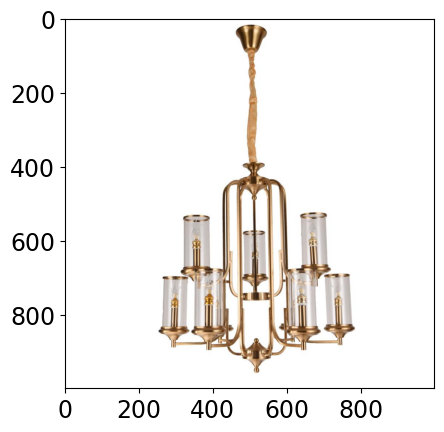

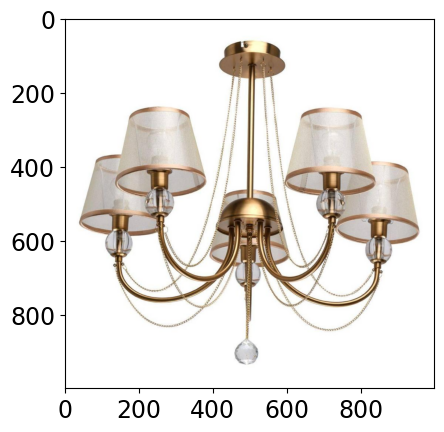

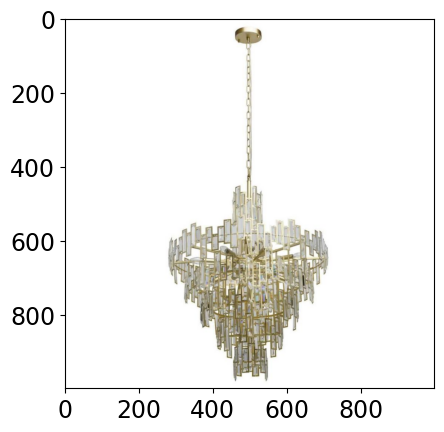

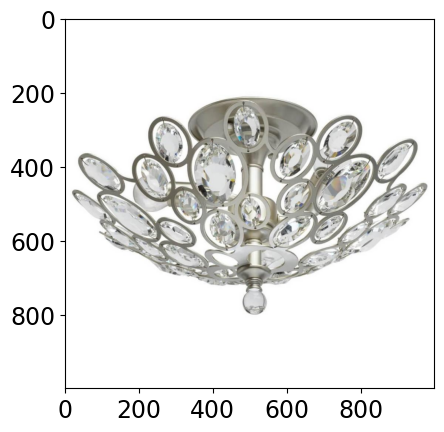

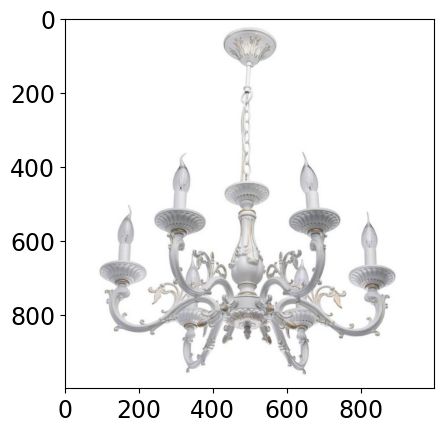

In [14]:
for _, imgmeta in lamps.head().iterrows():
	show_img(imgmeta.image)

In [15]:
lamps.tail()

,image,brand
20950,model/Omnilux/www.msveta.ru-upload-iblock-e03-...,Omnilux
20951,model/Omnilux/www.msveta.ru-upload-iblock-a4e-...,Omnilux
20952,model/Omnilux/www.msveta.ru-upload-iblock-5a9-...,Omnilux
20953,model/American Fashion Light/www.msveta.ru-upl...,American Fashion Light
20954,model/American Fashion Light/www.msveta.ru-upl...,American Fashion Light


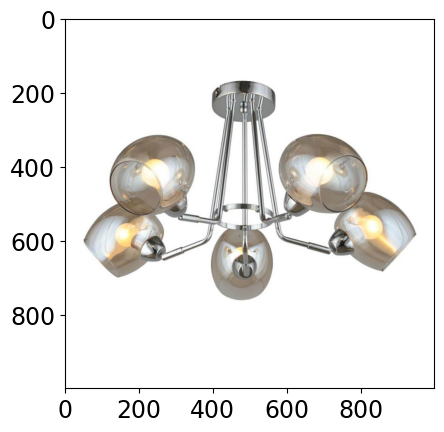

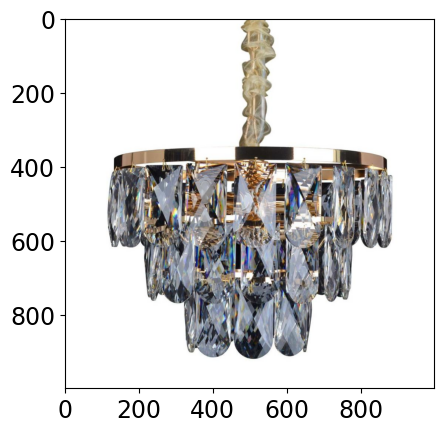

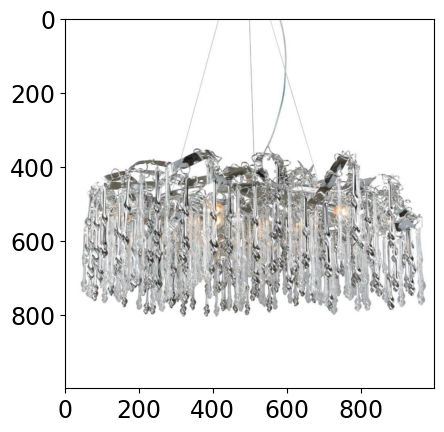

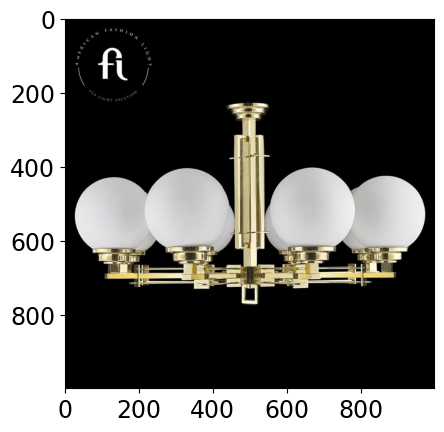

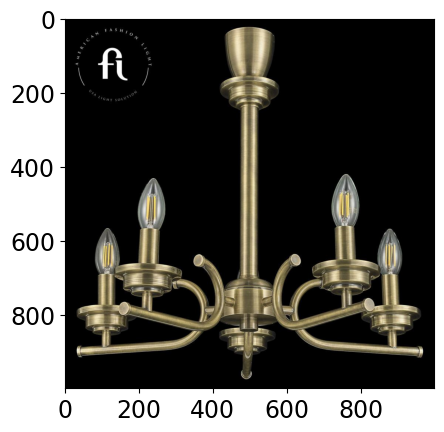

In [16]:
for _, imgmeta in lamps.tail().iterrows():
	show_img(imgmeta.image)

## Отчёт

### Обучение модели

#### Преобразование брендов в унитарный код

In [17]:
lamps_encoded = pandas.get_dummies(lamps.brand)

In [18]:
lamps_encoded.head()

,American Fashion Light,Aployt,Arte lamp,Arti Lampadari,Bogate's,BogateS,Bohemia Ivele Crystal,Chiaro,Citilux,Cristallo di Rocca,...,ST Luce,Sfera Sveta,Simple Story,Stilfort,TK Lighting,Toplight,Vele Luce,Vitaluce,Wertmark,Сонекс
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [19]:
lamps_encoded.tail()

,American Fashion Light,Aployt,Arte lamp,Arti Lampadari,Bogate's,BogateS,Bohemia Ivele Crystal,Chiaro,Citilux,Cristallo di Rocca,...,ST Luce,Sfera Sveta,Simple Story,Stilfort,TK Lighting,Toplight,Vele Luce,Vitaluce,Wertmark,Сонекс
20950,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
20951,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
20952,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
20953,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
20954,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


#### Разбиение на `valid`, `test`

In [20]:
features = copy.deepcopy(lamps.image).tolist()
target = []
for _, bs in lamps_encoded.iterrows():
	for i in range(len(lamps_encoded.columns)):
		if bs[lamps_encoded.columns[i]]:
			target.append(i)
			break

In [21]:
features_train, features_test, target_train, target_test = sklearn.model_selection.train_test_split(features, target, test_size = 0.5, random_state = 42)

#### Вспомогательные детали

##### Классификатор

In [22]:
class ImageClassificator(torch.nn.Module):
	def __init__(self, num_features):
		super(ImageClassificator, self).__init__()
		self.num_features = num_features
		self.conv1 = torch.nn.Conv2d(in_channels = 3, out_channels = num_features, kernel_size = 5, stride = 1, padding = 1)  # сверточный слой (умножение и сложение объекта размерами 5x5, padding - забивание нулями недостаточное место)
		self.bn1 = torch.nn.BatchNorm2d(num_features)                                                                         # нормализация батча (для получения одинаковых фильтров схожих фотографий) по всем out_channels из предудщего шага
		self.conv2 = torch.nn.Conv2d(in_channels = num_features, out_channels = num_features, kernel_size = 5, stride = 1, padding = 1)
		self.bn2 = torch.nn.BatchNorm2d(num_features)
		self.pool = torch.nn.MaxPool2d(2, 2)                                                                        # слой уплотнения 2x2 пикселей до одного
		self.conv4 = torch.nn.Conv2d(in_channels = num_features, out_channels = num_features * 2, kernel_size = 5, stride = 1, padding = 1)
		self.bn4 = torch.nn.BatchNorm2d(num_features * 2)
		self.conv5 = torch.nn.Conv2d(in_channels = num_features * 2, out_channels = num_features * 2, kernel_size = 5, stride = 1, padding = 1)
		self.bn5 = torch.nn.BatchNorm2d(num_features * 2)

	def forward(self, x):
		output = torch.nn.functional.relu(self.bn1(self.conv1(x)))      
		output = torch.nn.functional.relu(self.bn2(self.conv2(output)))     
		output = self.pool(output)                        
		output = torch.nn.functional.relu(self.bn4(self.conv4(output)))     
		output = torch.nn.functional.relu(self.bn5(self.conv5(output)))     
		output = output.view(-1, self.num_features * 2 * 10 * 10) # последний слой преобразуем в вектор для подачи в полносвязный слой
		fc1 = torch.nn.Linear(self.num_features * 2 * 10 * 10, len(x)) # линейное преобразование
		output = fc1(output)
		return output

##### Датасет

In [23]:
class ImageStorage(torch.utils.data.Dataset):
	def __init__(self, images, labels, transform):
		self.images = images
		self.labels = torch.Tensor(labels)
		self.transform = transform

	def __getitem__(self, idx):
		imgpath = self.images[idx]
		image = PIL.Image.open(imgpath).convert("RGB")
		image = image.resize(IMG_RESIZED_SIZE)
		image = self.transform(image)
		return image, self.labels[idx]

	def __len__(self):
		return len(self.images)

##### Свёртка

In [24]:
transform = torchvision.transforms.Compose([
		torchvision.transforms.Resize(IMG_RESIZED_SIZE),
		torchvision.transforms.ToTensor(),
		torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
	]
)

#### Загрузчик

In [25]:
train_storage = ImageStorage(features_train, target_train, transform)
test_storage = ImageStorage(features_test, target_test, transform)

In [26]:
train_iterator = torch.utils.data.DataLoader(train_storage, batch_size = MDL_BATCH_SIZE, shuffle = True)
test_iterator = torch.utils.data.DataLoader(test_storage, batch_size = MDL_BATCH_SIZE, shuffle = True)

#### Модель

In [27]:
classificator = ImageClassificator(len(lamps_encoded.columns))
criteria = MDL_CRITERIA()
optimizer = MDL_OPTIMIZER(classificator.parameters(), lr = MDL_LEARNING_RATE)
train_loss = []
test_loss = []

In [28]:
best_loss = float("inf")

In [29]:
for _ in tqdm.tqdm(range(MDL_EPOCHS)):
	classificator.train()

	current_train_loss = 0
	current_test_loss = 0

	for w, e in tqdm.tqdm(train_iterator):
		optimizer.zero_grad()
		pred = classificator(w)
		loss = criteria(pred, e.float())
		loss.backward()
		optimizer.step()
		current_train_loss += loss.item()

	classificator.eval()

	with torch.no_grad():
		for w, e in tqdm.tqdm(test_iterator):
			pred = classificator(w)
			loss = criteria(pred, e.float())
			current_test_loss += loss.item()

	train_loss.append(current_train_loss / len(train_iterator))
	test_loss.append(current_test_loss / len(test_iterator))

	if test_loss[-1] < best_loss:
		best_loss = test_loss[-1]
		torch.save(classificator.state_dict(), MDL_BEST_MODEL)

  0%|          | 0/10 [00:00<?, ?it/s]/home/saveliy-vm/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/saveliy-vm/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 328/328 [01:31<00:00,  3.59it/s]
/home/saveliy-vm/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([14, 14])).

In [30]:
classificator.load_state_dict(torch.load(MDL_BEST_MODEL))

<All keys matched successfully>

In [31]:
def draw_errors(errors_train, errors_test, params):
	title = "Average error by epoch"
	xlabel = "Epoch"
	ylabel = "Error"
	matplotlib.pyplot.figure(figsize = PLT_FIGSIZE)
	matplotlib.pyplot.title(title)
	matplotlib.pyplot.plot(params, errors_train, color = CLR_TRAIN, label = "TRAIN")
	matplotlib.pyplot.plot(params, errors_test, color = CLR_TEST, label = "TEST")
	matplotlib.pyplot.xlabel(xlabel)
	matplotlib.pyplot.ylabel(ylabel)
	matplotlib.pyplot.legend()
	matplotlib.pyplot.show()

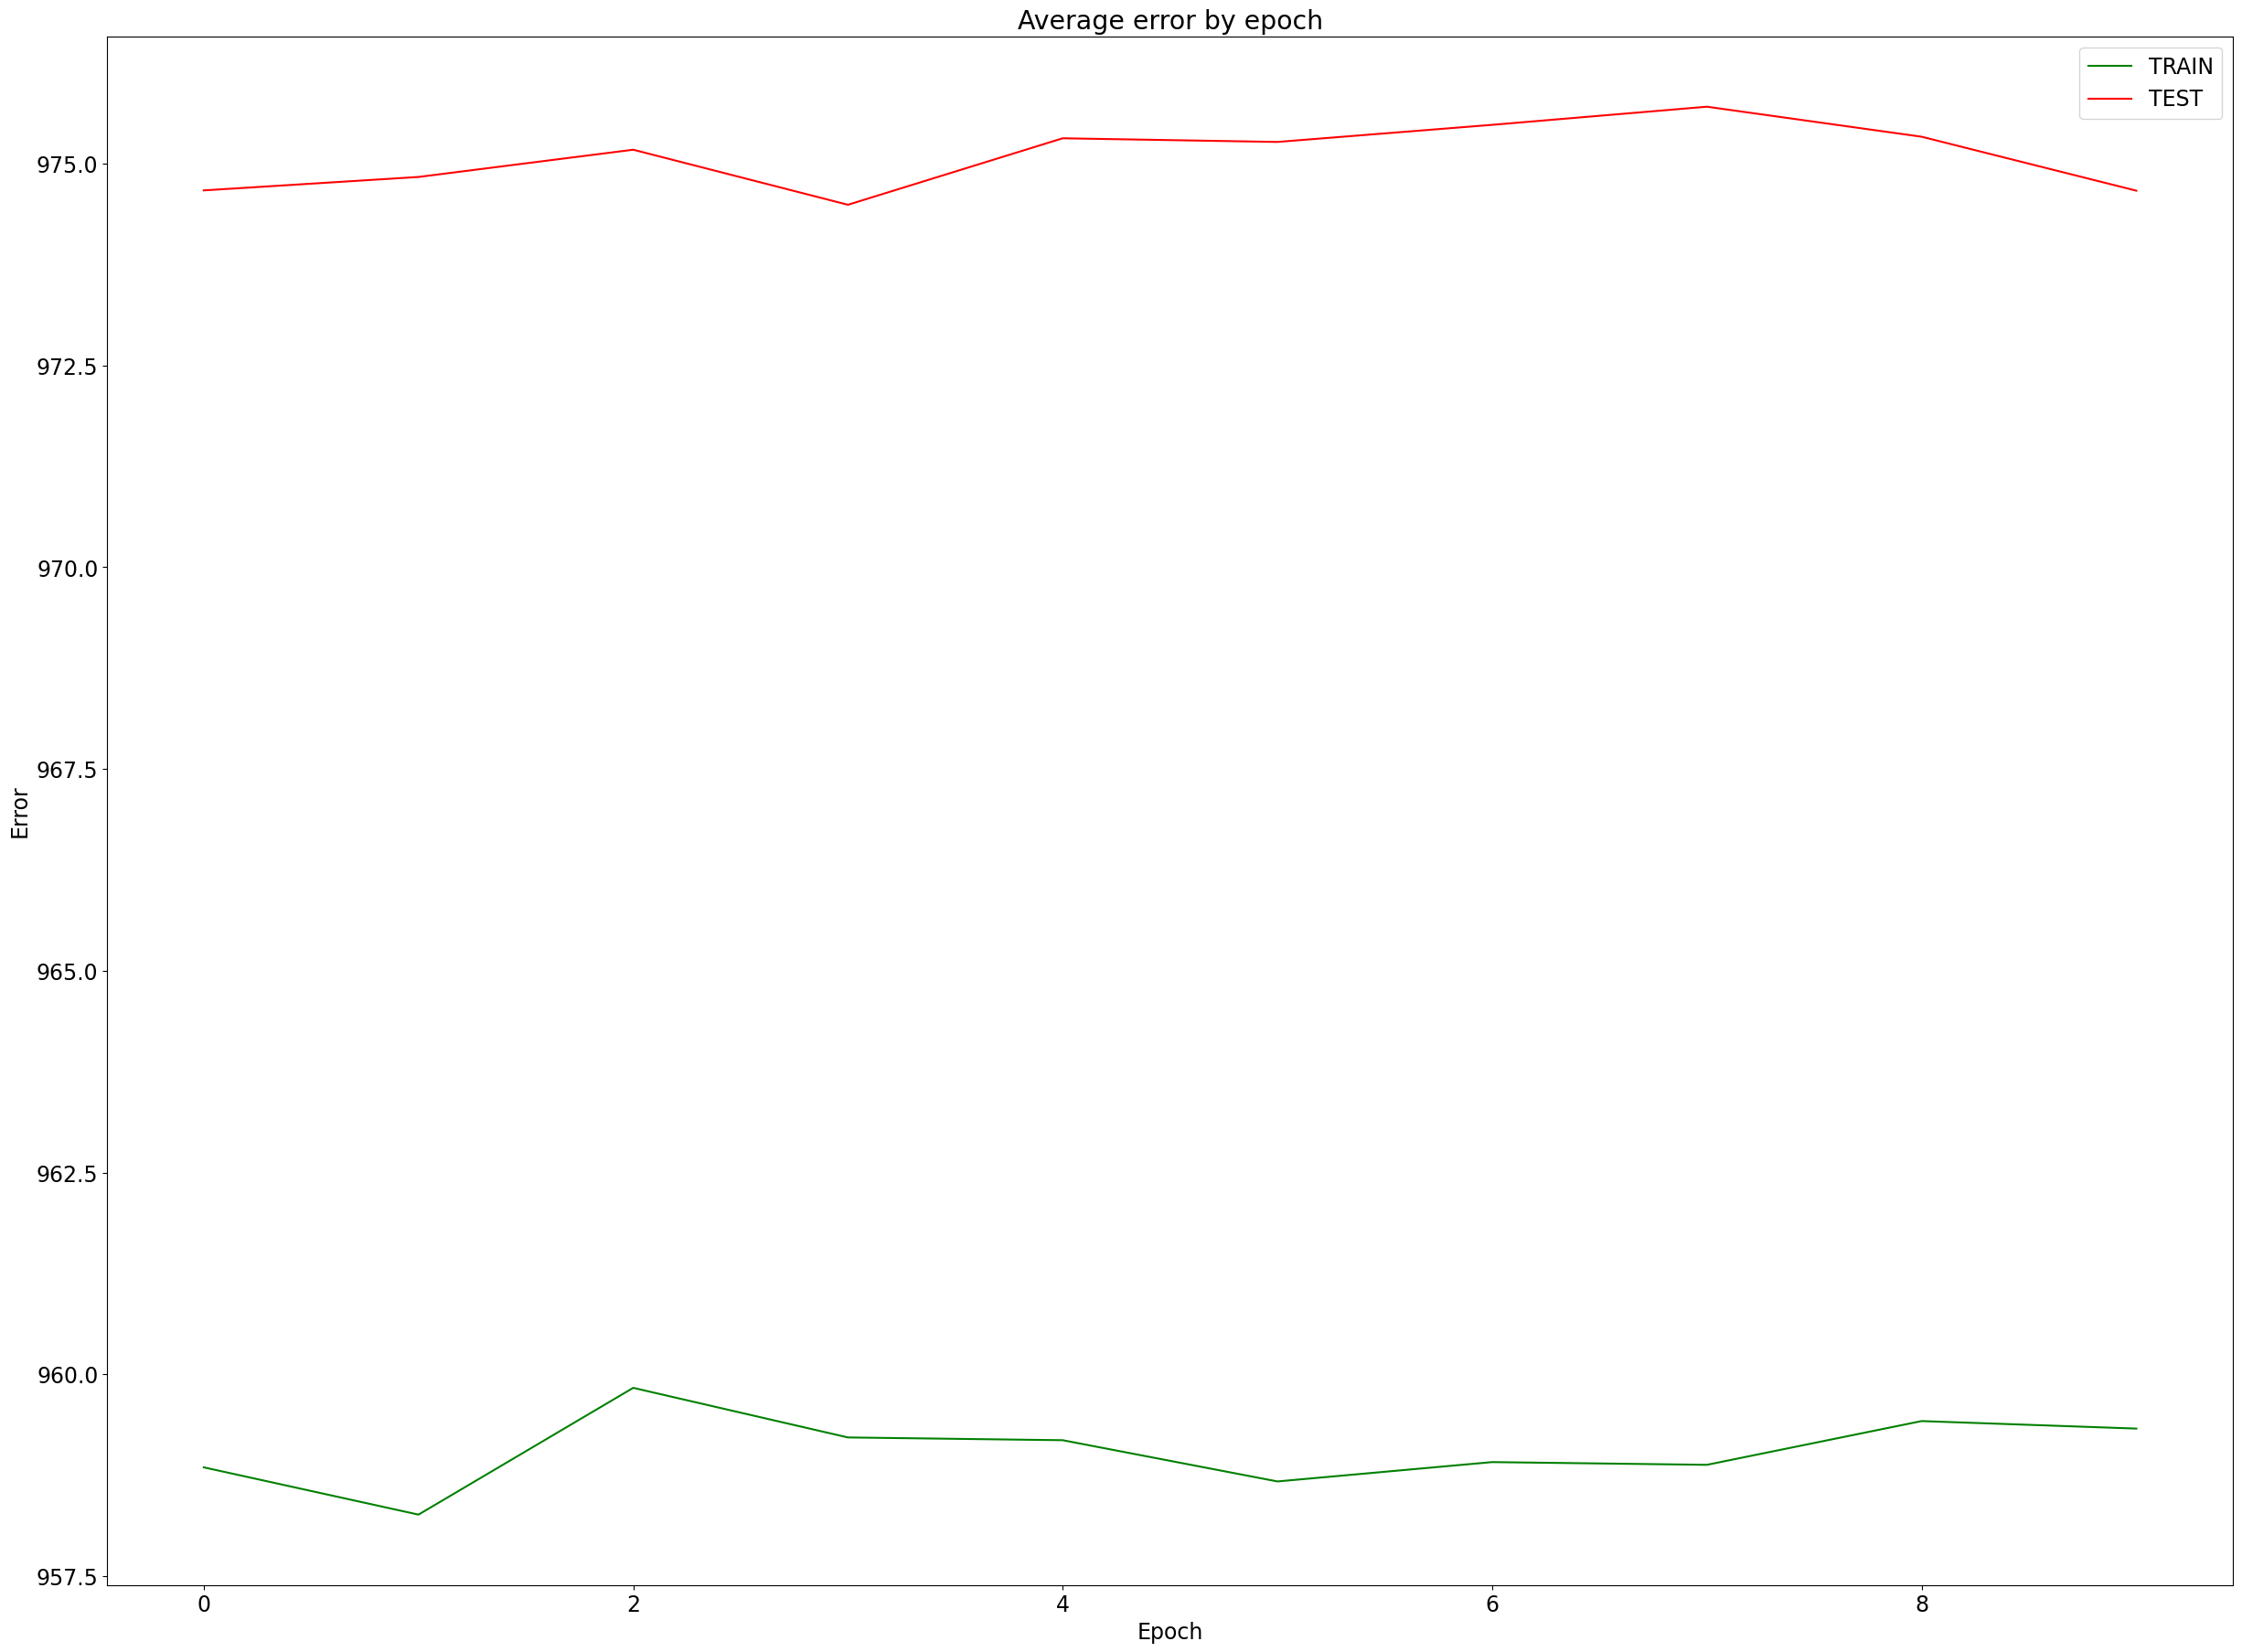

In [32]:
draw_errors(train_loss, test_loss, range(0, MDL_EPOCHS))

### Демонстрация работоспособности

In [33]:
classificator.eval()

ImageClassificator(
  (conv1): Conv2d(3, 58, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(58, 58, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(58, 116, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(116, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(116, 116, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(116, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [34]:
def show_imgs(image):
	image = image / 2 + 0.5
	npimg = image.numpy()
	matplotlib.pyplot.figure(figsize = PLT_FIGSIZE)
	matplotlib.pyplot.imshow(numpy.transpose(npimg, (1, 2, 0)))
	matplotlib.pyplot.show()

  0%|          | 0/328 [00:00<?, ?it/s]

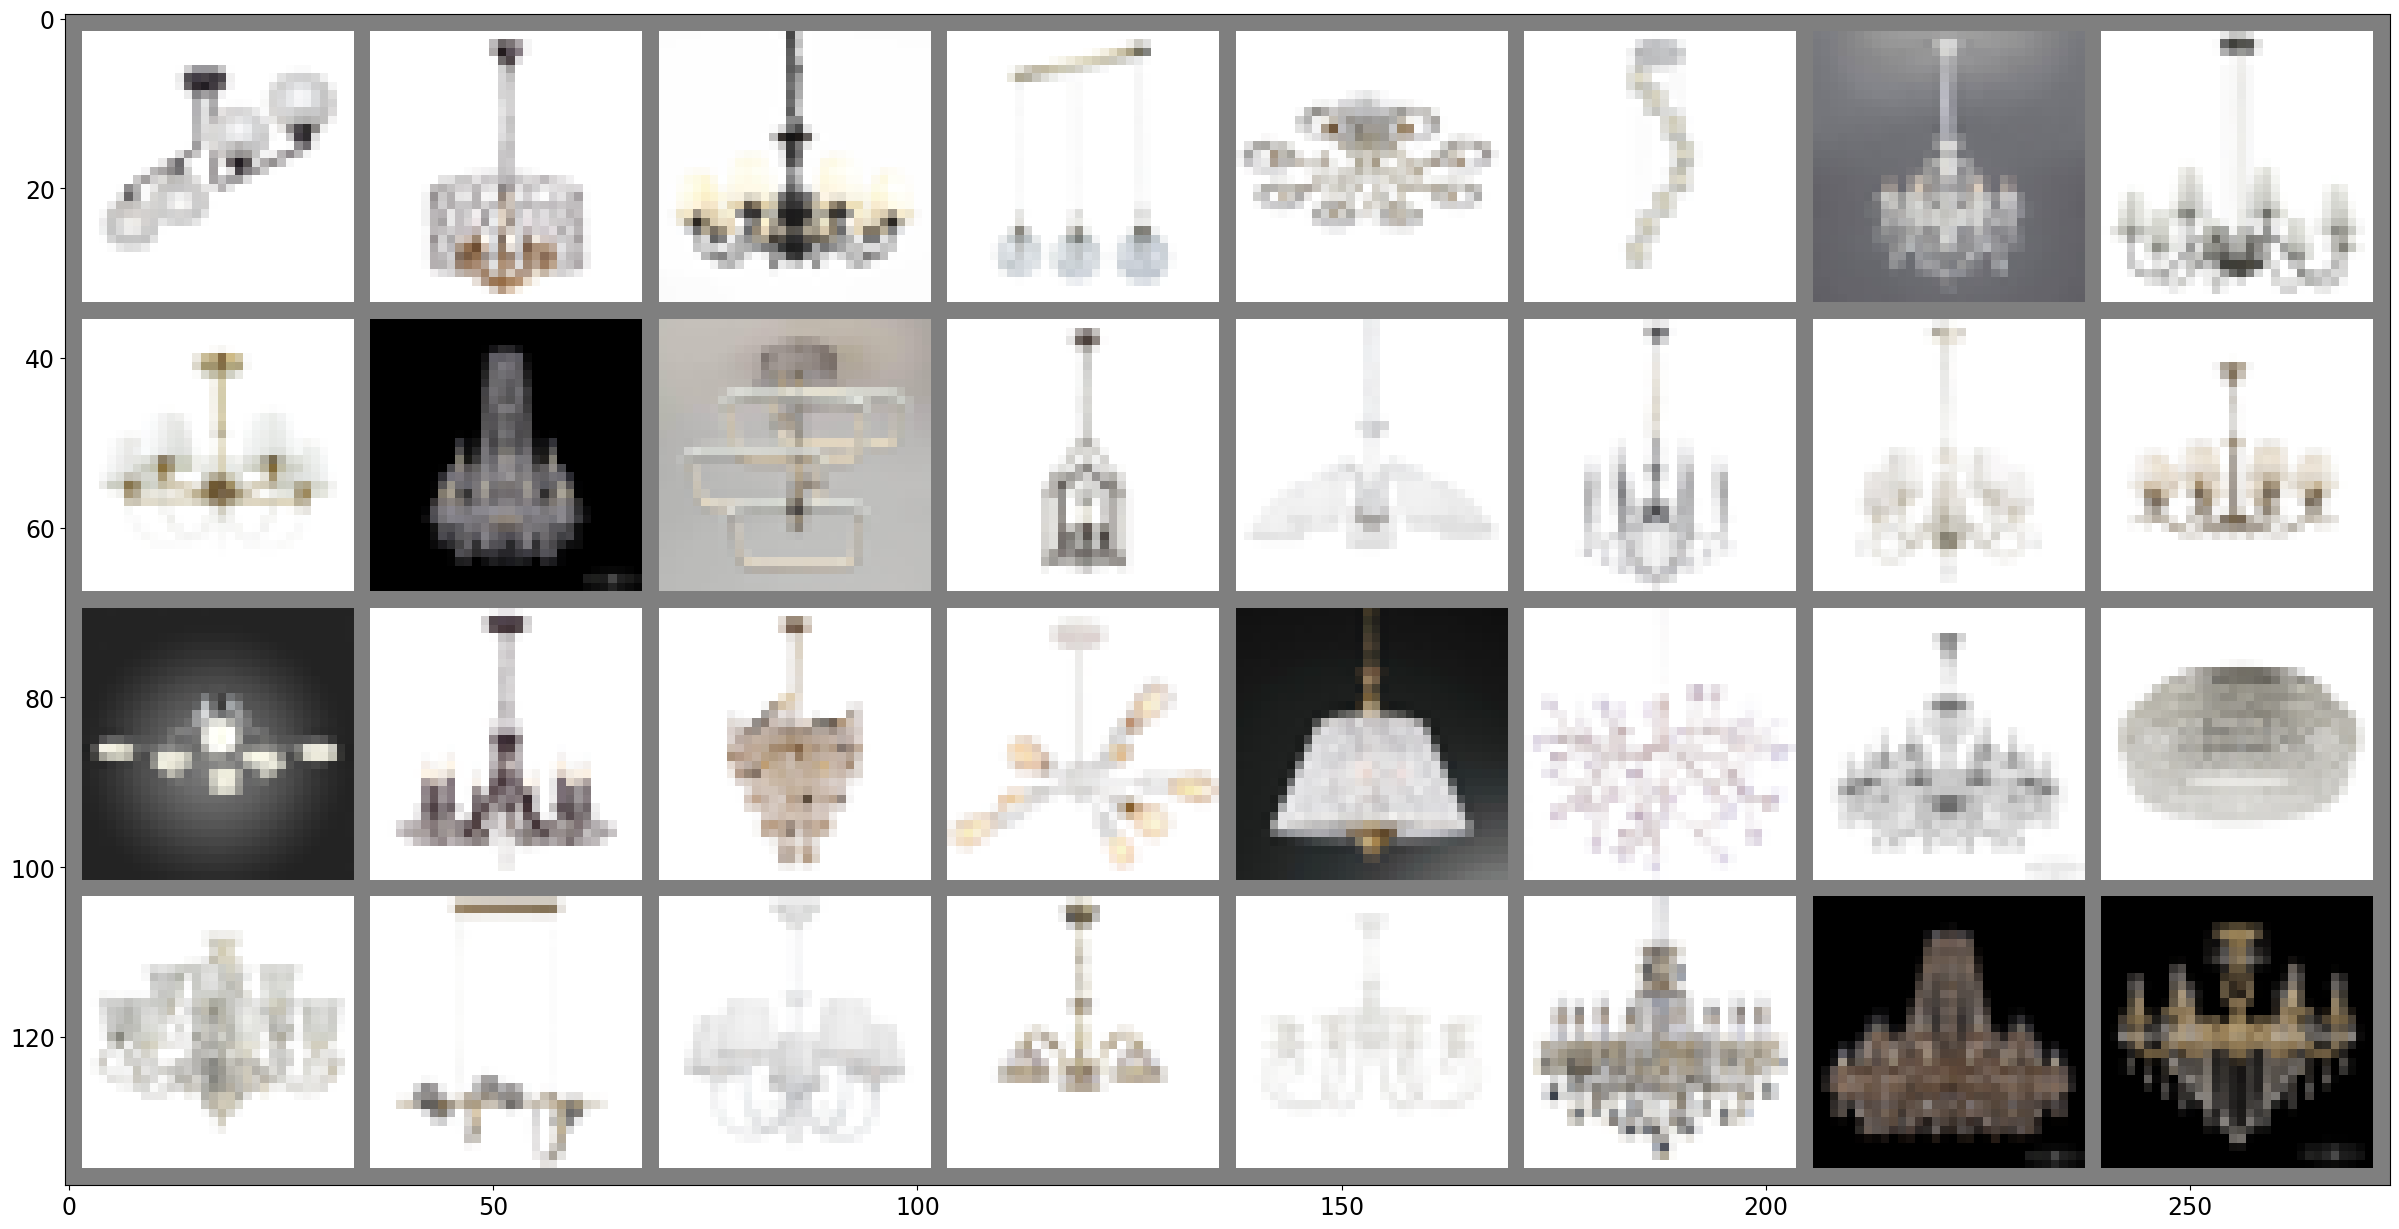

  0%|          | 0/328 [00:00<?, ?it/s]

Predicted:  BogateS, De City, De City, BogateS, BogateS, BogateS, De City, BogateS, BogateS, Indigo, Indigo, BogateS, BogateS, BogateS, BogateS, BogateS, Chiaro, De City, BogateS, BogateS, F-Promo, BogateS, De City, Indigo, BogateS, BogateS, BogateS, BogateS, BogateS, Indigo, Indigo, Chiaro


In [35]:
with torch.no_grad():
	for w, e in tqdm.tqdm(test_iterator):
		pred = classificator(w)
		_, index = torch.max(pred, 1)
		predited = index.tolist()
		show_imgs(torchvision.utils.make_grid(w))
		print('Predicted: ', ', '.join(f'{lamps_encoded.columns[predited[j]]:5s}' for j in range(len(predited))))
		break